# Introduction

Try images.

In [1]:
# Querying
import earthaccess                                          # accessing earthdata
import pprint                                               # for nice printing
import logging                                              # for nice displaying of requests
import json   
from shapely.geometry import shape, GeometryCollection      # reformatting the geojson file
import geojson 

# Processing
import xarray as xr                                         # for reading data
import rioxarray as rio                                     # geodata processing; gdal > rasterio > xarray > rioxarray
import numpy as np                                          # math

# Parsing
import os

# Plotting
# import hvplot.xarray                                      # create interactive plots of xarray objects
from geopandas import read_file                             # visualizing & plotting the shapefile 
import matplotlib.pyplot as plt                             # plots
import cartopy.crs as ccrs                                  # for geoaxes
import matplotlib.ticker as mticker                         # for tick marks & nice gridlines

%config InlineBackend.figure_format = 'png2x'               # higher resolution plots in notebook

# Authentication
To access data you need to log in with your earthdata account (you may search without logging in). If you don't have one, you can make an account [here](https://urs.earthdata.nasa.gov/users/new).

In [2]:
auth = earthaccess.login()

Enter your Earthdata Login username:  alexisarlen
Enter your Earthdata password:  ········


# Querying available datasets
Next, we'll search for datasets containing the MODIS optical images. We can get these from Terra (*MOD02QKM*) or Aqua (*MYD02QKM*). Even though we know which product we want, it can be helpful to print the metadata from the dataset query to be sure our data query has the right parameters.

In [6]:
query = earthaccess.search_datasets(keyword="MOD02QKM",)

Print the first 10 lines from the query, comprising the first two datasets.

In [7]:
for collection in query[:10]:
    pprint.pprint(collection.summary(), sort_dicts=True, indent=4)
    print('')  # Add a space between collections for readability

{   'concept-id': 'C1426415307-LANCEMODIS',
    'file-type': "[{'FormatType': 'Native', 'Fees': 'No Fee', 'Format': "
                 "'HDF-EOS', 'Media': ['Online (HTTPS)']}]",
    'get-data': [   'https://earthdata.nasa.gov/earth-observation-data/near-real-time/download-nrt-data/modis-nrt',
                    'http://lance3.modaps.eosdis.nasa.gov/data_products/',
                    'https://nrt3.modaps.eosdis.nasa.gov/archive/allData/61/MOD02HKM/'],
    'short-name': 'MOD02HKM',
    'version': '6.1NRT'}

{   'cloud-info': {   'Region': 'us-west-2',
                      'S3BucketAndObjectPrefixNames': [   's3://prod-lads/MOD02HKM'],
                      'S3CredentialsAPIDocumentationURL': 'https://data.laadsdaac.earthdatacloud.nasa.gov/s3credentialsREADME',
                      'S3CredentialsAPIEndpoint': 'https://data.laadsdaac.earthdatacloud.nasa.gov/s3credentials'},
    'concept-id': 'C1378577630-LAADS',
    'file-type': "[{'Format': 'HDF-EOS', 'FormatType': 'Native', 'Media'

We see that the first dataset in the query is the one we're looking for. Now, lets access the data. 

# Accessing Data

In [8]:
# Define the longitude and latitude coordinates for Weddell Sea sea ice box
box_lon = [-43.91, -36.63, -22.95, -28.9, -43.91]
box_lat = [-63.52, -59.44, -63.20, -68.09, -63.52]

# Combine the coordinates into a list of [lon, lat] pairs
coordinates = list(zip(box_lon, box_lat))

# Create a GeoJSON Polygon feature
polygon = geojson.Polygon([coordinates])

# Create a GeoJSON Feature
feature = geojson.Feature(geometry=polygon, properties={})

# Create a GeoJSON FeatureCollection
feature_collection = geojson.FeatureCollection([feature])

# Save the GeoJSON FeatureCollection to a file
with open('weddell_siz.geojson', 'w') as f:
    json.dump(feature_collection, f, indent=2)

### Parameters that go into the search_data function
**Data:**
- short_name = ''
- version = ''
- cloud_hosted = True/False
  
**Region:**
- bounding_box = (lon min, lat min, lon max, lat max)
- point = (lon, lat)

**Time frame:**
- temporal = ('yyyy-mm-dd', 'yyyy-mm-dd') start and end dates

**Other Parameters:**
- count = maximum number of returned results

For now, we'll get the set the bounding_box from the extent from the geojson file. I'm not sure what keyword to use if I wanted to preserve an irregular shape for the geojson file. Perhaps polygon? 

In [9]:
# Open a geojson of our area of interest
with open("./weddell_siz.geojson") as f:
    features = json.load(f)["features"]

weddell = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in features])
weddell_gdf = read_file('weddell_siz.geojson')
weddell_gdf.explore()

In [10]:
N = 260

results = earthaccess.search_data(
    short_name = 'MYD02QKM',
    version = '6.1',
    cloud_hosted = True,
    bounding_box = weddell.bounds,
    temporal = ('2017-09-01','2021-10-10'),
    count = N
)

Now, let's display every 60th file we've found.

In [11]:
for i, r in enumerate(results):
    if i % 60 == 0:
        display(r)

Collection: {'ShortName': 'MYD02QKM', 'Version': '6.1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 2.56419, 'Latitude': -51.795236}, {'Longitude': -34.633849, 'Latitude': -56.852943}, {'Longitude': -38.737607, 'Latitude': -74.972958}, {'Longitude': 25.522663, 'Latitude': -65.875971}, {'Longitude': 2.56419, 'Latitude': -51.795236}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2017-09-01T15:20:00.000Z', 'EndingDateTime': '2017-09-01T15:25:00.000Z'}}
Size(MB): 147.5673828125
Data: ['https://data.laadsdaac.earthdatacloud.nasa.gov/prod-lads/MYD02QKM/MYD02QKM.A2017244.1520.061.2017258225607.hdf']

Collection: {'ShortName': 'MYD02QKM', 'Version': '6.1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -56.65258, 'Latitude': -51.270917}, {'Longitude': -93.373666, 'Latitude': -56.258057}, {'Longitude': -97.130416, 'Latitude': -74.381409}, {'Longitude': -34.35569, 'Latitude': -65.496801}, {'Longitude': -56.65258, 'Latitude': -51.270917}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2017-09-11T19:15:00.000Z', 'EndingDateTime': '2017-09-11T19:20:00.000Z'}}
Size(MB): 156.668856620789
Data: ['https://data.laadsdaac.earthdatacloud.nasa.gov/prod-lads/MYD02QKM/MYD02QKM.A2017254.1915.061.2017261030723.hdf']

Collection: {'ShortName': 'MYD02QKM', 'Version': '6.1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -5.984964, 'Latitude': -47.332806}, {'Longitude': -39.469054, 'Latitude': -51.850718}, {'Longitude': -41.239777, 'Latitude': -70.027021}, {'Longitude': 12.10065, 'Latitude': -62.451648}, {'Longitude': -5.984964, 'Latitude': -47.332806}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2017-09-22T15:40:00.000Z', 'EndingDateTime': '2017-09-22T15:45:00.000Z'}}
Size(MB): 158.115416526794
Data: ['https://data.laadsdaac.earthdatacloud.nasa.gov/prod-lads/MYD02QKM/MYD02QKM.A2017265.1540.061.2017286052445.hdf']

Collection: {'ShortName': 'MYD02QKM', 'Version': '6.1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -49.22062, 'Latitude': -52.516962}, {'Longitude': -87.230868, 'Latitude': -57.694312}, {'Longitude': -91.958877, 'Latitude': -75.786324}, {'Longitude': -25.305166, 'Latitude': -66.369025}, {'Longitude': -49.22062, 'Latitude': -52.516962}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2017-10-01T18:50:00.000Z', 'EndingDateTime': '2017-10-01T18:55:00.000Z'}}
Size(MB): 155.075289726257
Data: ['https://data.laadsdaac.earthdatacloud.nasa.gov/prod-lads/MYD02QKM/MYD02QKM.A2017274.1850.061.2017286225030.hdf']

Collection: {'ShortName': 'MYD02QKM', 'Version': '6.1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -61.611586, 'Latitude': -60.455598}, {'Longitude': -111.021345, 'Latitude': -67.335122}, {'Longitude': -137.568205, 'Latitude': -84.802011}, {'Longitude': -23.762342, 'Latitude': -70.490612}, {'Longitude': -61.611586, 'Latitude': -60.455598}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2017-10-10T20:20:00.000Z', 'EndingDateTime': '2017-10-10T20:25:00.000Z'}}
Size(MB): 151.231258392334
Data: ['https://data.laadsdaac.earthdatacloud.nasa.gov/prod-lads/MYD02QKM/MYD02QKM.A2017283.2020.061.2017285201131.hdf']

# Plotting some example data

Lexi's workflow for fracture detection:

1. Download data overlapping region.
2. Reproject to lat lon? (ideally wanna avoid this step)
3. Crop to box (should project box to EPSG of MODIS image; need to figure out how to do)
4. Extract matrix representing region
5. Edge detect (reduces memory b/c edge detected image is binary; employ sparse methods)
6. Tile matrix
7. Perform lagged subtraction across tiles (no advection at first)

**Remark:** *This is going to require a LOT of memory... GPU?*

In [13]:
ds = xr.open_dataset('MYD02QKM.A2017244.1520.061.2017258225607.hdf', engine = 'rasterio')

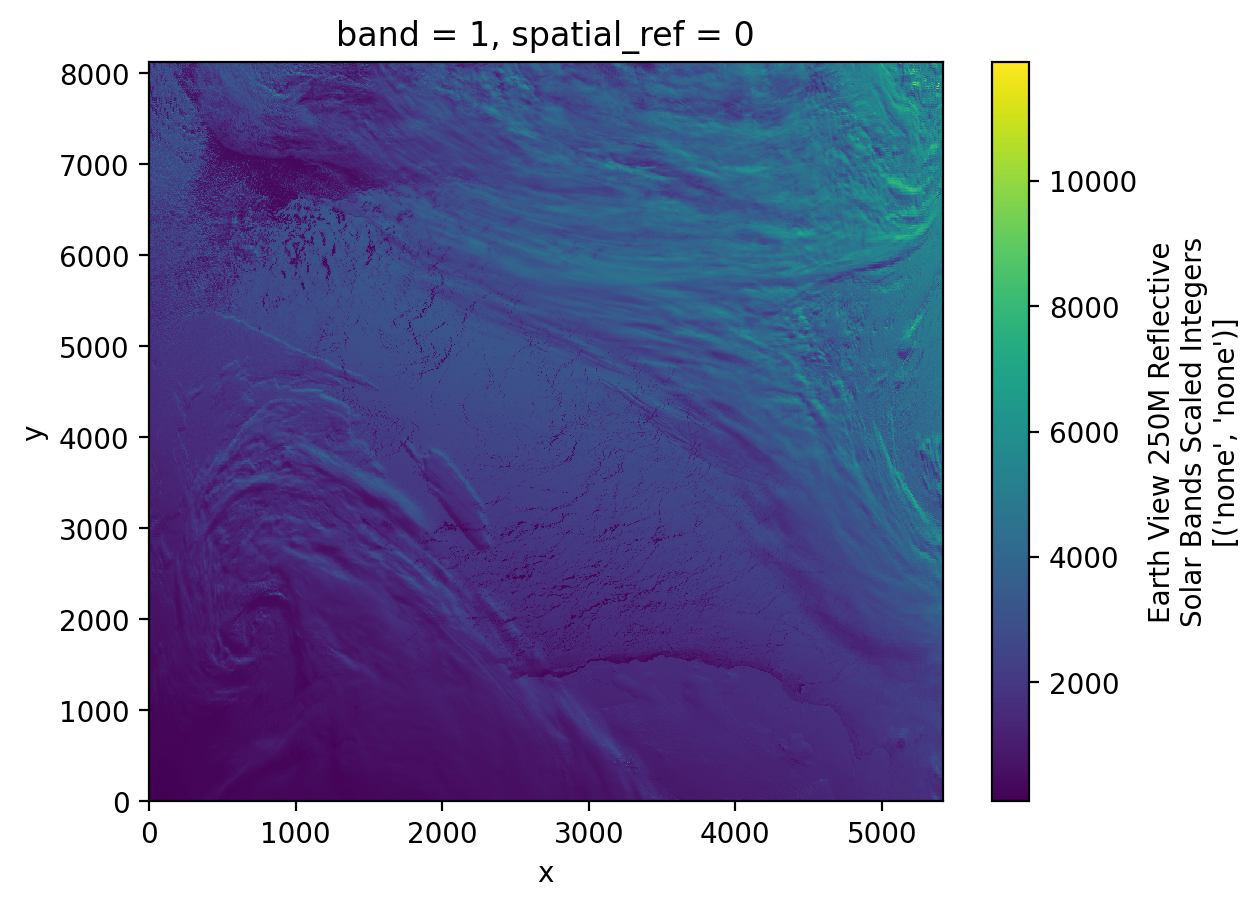

In [28]:
# band 0
ds['EV_250_RefSB'][0, :, :].plot()

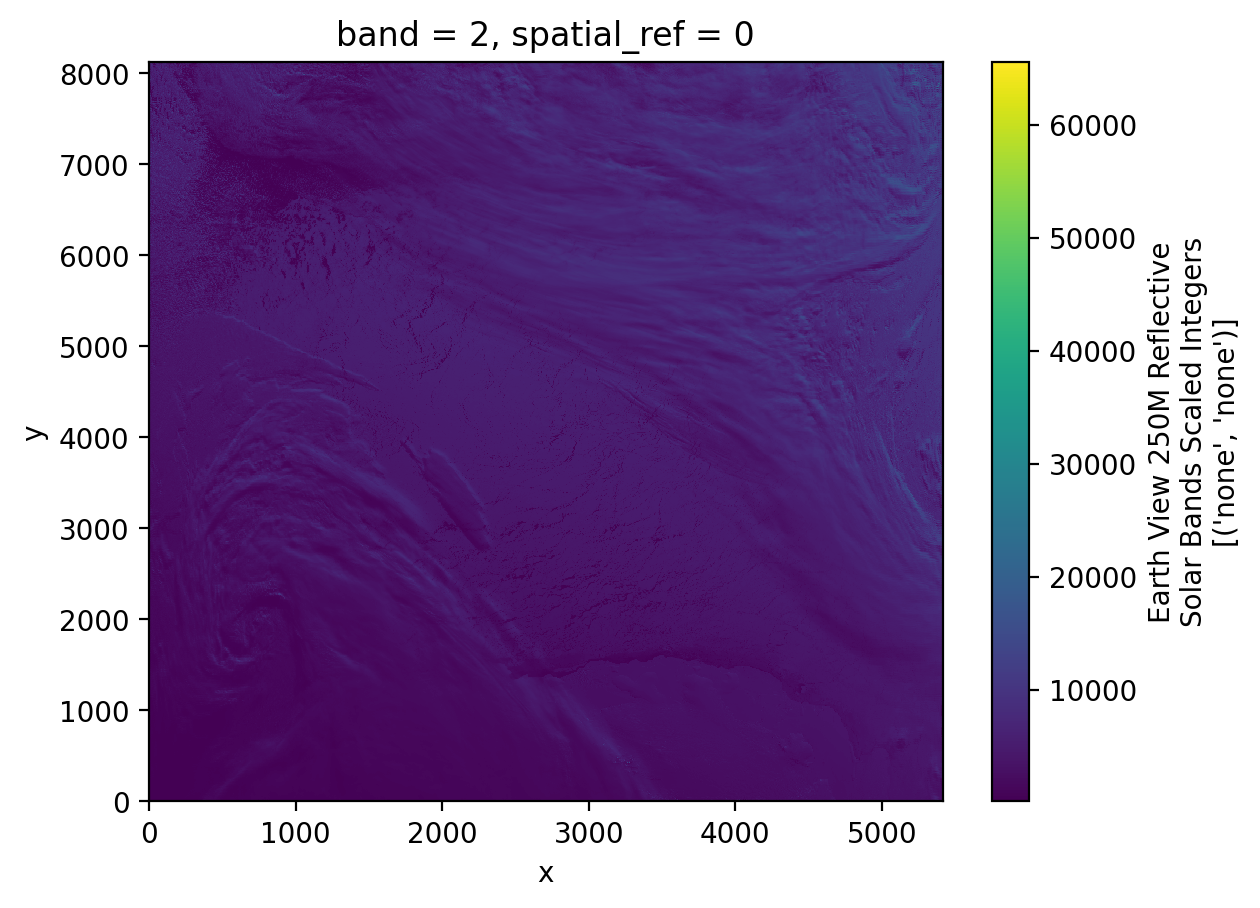

In [26]:
# band 1
ds['EV_250_RefSB'][1, :, :].plot()

# Downloading data

In [9]:
for i,r in enumerate(results): 
    if i % 10 == 0:
        earthaccess.download(r, "./data")
        date = r['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'][:10]
        print(f'Downloading data from {date}')

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

```{note}
If you like using `git add .` to commit changes, make sure to create a *.gitignore* file so that you don't commit the .hdf files on accident and slow down commits for other snowmelt-timing users. 

A gitignore file can be created from the command line. Type `nano .gitignore` to open a new file with the name .gitignore. Then, add in all the files you'd like to be ignored in the commit with a return between each file. To ignore all hdf files, type '*.hdf* into the file. Press Ctrl + X to exit, then Y to save your changes. Commit and push the .gitignore file. 
```

# Data processing & visualization
Now, we will read the data using rioxarray and plot it using matplotlib. First, we'll consider an example image to go through the basics of rioxarray, matplotlib, and cartopy.

With rioxarray, xarray can now be used to open MODIS data so long as the engine is specified as rasterio. Just importing rasterio without rioxarray will not allow you to use the rasterio engine to open MODIS data as an xarray dataset. 

In [29]:
ds = xr.open_dataset('MOD10A1F.A2020336.h09v05.061.2020357073222.hdf', engine = 'rasterio')

Let's print the dataset to see the coordinate system and the variables included. 

We see that x and y are in units of meters rather than latitude and longitude. We will want to correct this before plotting by reprojecting the data. The spatial_ref coordinate contains details about the data's current coordinate system. 

We see that in addition to the data we requested, the cloud gap filled (CGF) NDSI Snow Cover, we got a few other variables including the MOD10A1 product which contains no backfilling. By clicking the piece of paper icon next to each variable, more information about the data is provided including how the non-snow values are defined. 

In [30]:
ds

<xarray.Dataset> Size: 115MB
Dimensions:                  (band: 1, x: 2400, y: 2400)
Coordinates:
  * band                     (band) int64 8B 1
  * x                        (x) float64 19kB -1.001e+07 ... -8.896e+06
  * y                        (y) float64 19kB 4.448e+06 4.447e+06 ... 3.336e+06
    spatial_ref              int64 8B ...
Data variables:
    CGF_NDSI_Snow_Cover      (band, y, x) float32 23MB ...
    Cloud_Persistence        (band, y, x) float32 23MB ...
    Basic_QA                 (band, y, x) float32 23MB ...
    Algorithm_Flags_QA       (band, y, x) float32 23MB ...
    MOD10A1_NDSI_Snow_Cover  (band, y, x) float32 23MB ...
Attributes: (12/64)
    ALGORITHMPACKAGEACCEPTANCEDATE:      12-2017
    ALGORITHMPACKAGEMATURITYCODE:        Normal
    ALGORITHMPACKAGENAME:                MOD_PR10A1F
    ALGORITHMPACKAGEVERSION:             1
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ...                                  ...
    SPSOPARAMETERS:                      none
    TileID:                              51009005
    Time Series Day:                     62
    VERSIONID:                           61
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              -117.486656023174

ds.rio.reproject_match

In [32]:
ds_reprojected = ds.rio.reproject('EPSG:4326') # lat lon

In [33]:
ds_reprojected

<xarray.Dataset> Size: 79MB
Dimensions:                  (x: 3153, y: 1256, band: 1)
Coordinates:
  * x                        (x) float64 25kB -117.5 -117.5 ... -92.39 -92.38
  * y                        (y) float64 10kB 40.0 39.99 39.98 ... 30.01 30.0
  * band                     (band) int64 8B 1
    spatial_ref              int64 8B 0
Data variables:
    CGF_NDSI_Snow_Cover      (band, y, x) float32 16MB nan 0.0 0.0 ... 0.0 0.0
    Cloud_Persistence        (band, y, x) float32 16MB nan 0.0 0.0 ... 0.0 0.0
    Basic_QA                 (band, y, x) float32 16MB nan 0.0 0.0 ... 0.0 0.0
    Algorithm_Flags_QA       (band, y, x) float32 16MB nan 0.0 0.0 ... 64.0 64.0
    MOD10A1_NDSI_Snow_Cover  (band, y, x) float32 16MB nan 0.0 0.0 ... 0.0 0.0
Attributes: (12/64)
    ALGORITHMPACKAGEACCEPTANCEDATE:      12-2017
    ALGORITHMPACKAGEMATURITYCODE:        Normal
    ALGORITHMPACKAGENAME:                MOD_PR10A1F
    ALGORITHMPACKAGEVERSION:             1
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ...                                  ...
    SPSOPARAMETERS:                      none
    TileID:                              51009005
    Time Series Day:                     62
    VERSIONID:                           61
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              -117.486656023174

Observe that the CGF_NDSI_Snow_Cover variable has values greater than 100 to show where there is missing data, 201=no decision, 211=night, 237=inland water, 239=ocean, 250=cloud, 254=detector saturated, 255=fill. For our purposes, we will just set these to be nans. 

In [65]:
# Set all nan type values to 0
snow_cover_values = ds_reprojected['CGF_NDSI_Snow_Cover']
values_to_nan = [200, 201, 211, 237, 239, 250, 254, 255]
snow_cover_0_100 = snow_cover_values.where(~snow_cover_values.isin(values_to_nan), np.nan)

# Add the new variable to the dataset
ds_reprojected['snow_cover_0-100'] = snow_cover_0_100

Below, we'll plot the data. 

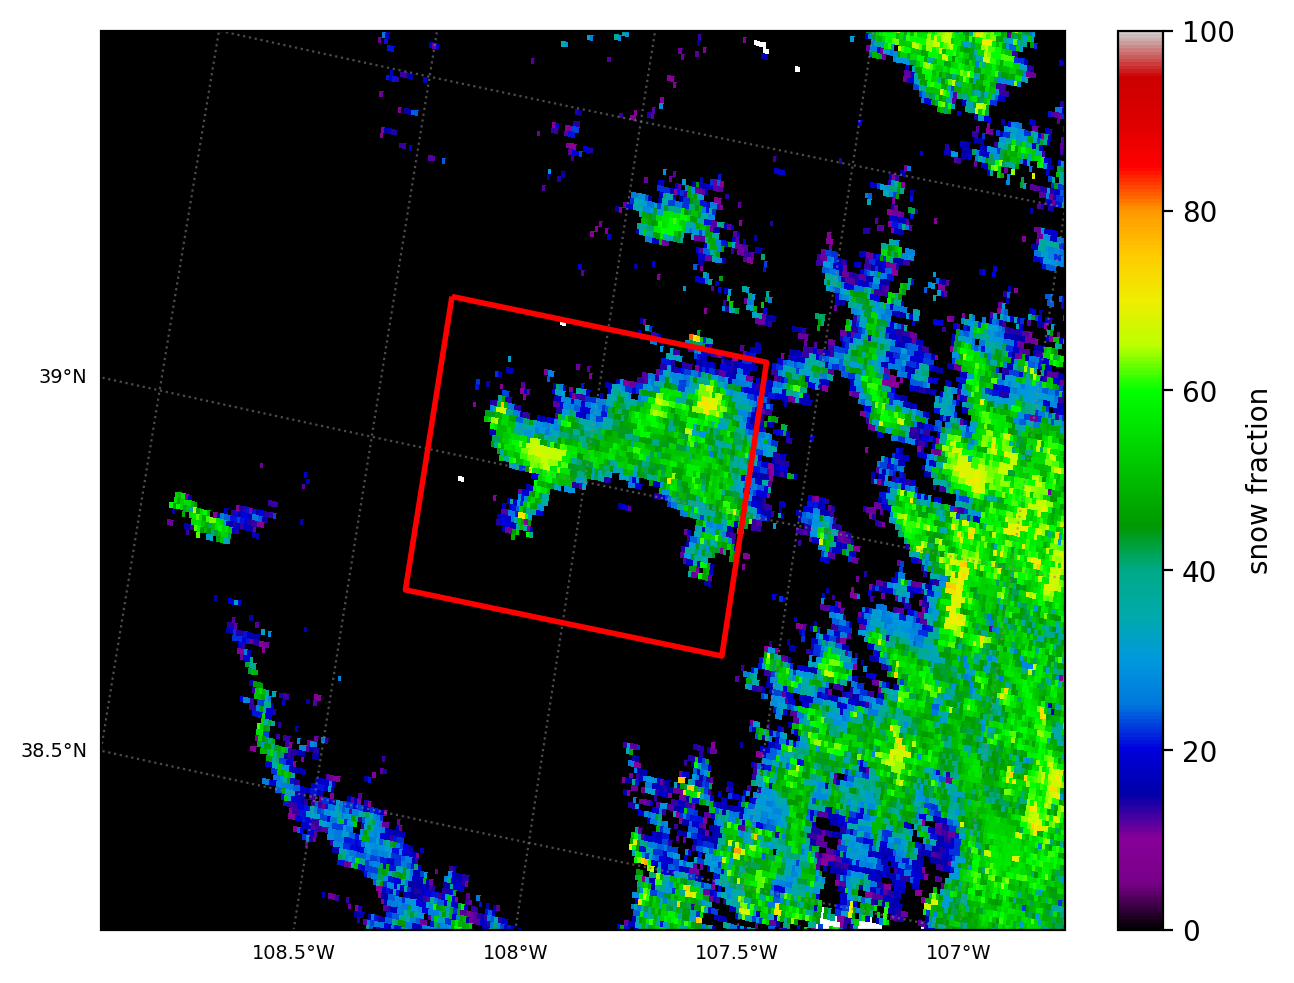

In [67]:
fig = plt.figure(layout = 'constrained')

# Format the geoaxes
map_extent = [-109, -107, 38.5, 39.5]
proj = ccrs.Orthographic(-90, 30)
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.set_extent(map_extent)

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,  color='gray', linestyle = ':', alpha=0.6)
gl.xlocator = mticker.FixedLocator(np.linspace(-109, -107, 5))
gl.ylocator = mticker.FixedLocator(np.linspace(38, 40, 5))
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.xlabel_style = {'size': 'x-small'}
gl.ylabel_style = {'size': 'x-small'}

# Plot the image data
cm = plt.pcolormesh(ds_reprojected['x'], ds_reprojected['y'], ds_reprojected['snow_cover_0-100'][0, :, :], 
                    vmin = 0, vmax = 100, cmap = 'nipy_spectral', transform = ccrs.PlateCarree())
plt.colorbar(cm, label = 'snow fraction')

# Plot the grandmesa shapefile
grandmesa_gdf.plot(ax=ax, edgecolor='red', lw = 2, facecolor='none', zorder = 12, transform = ccrs.PlateCarree())

plt.show()

# Preprocessing downloaded data. 

In [5]:
rootdir = 'data'
datasets = []
for fname in sorted(os.listdir(rootdir)):
    # Open the file
    fpath = os.path.join(rootdir, fname)
    ds = xr.open_dataset(fpath, engine = 'rasterio')
    
    # Reproject to latitude & longitude 
    reprojected_ds = ds.rio.reproject('EPSG:4326')
    ds.close()

    # Set all nan type values to 0
    snow_cover_values = reprojected_ds['CGF_NDSI_Snow_Cover']
    values_to_nan = [200, 201, 211, 237, 239, 250, 254, 255]
    snow_cover_0_100 = snow_cover_values.where(~snow_cover_values.isin(values_to_nan), np.nan)

    # Add the new variable to the dataset
    reprojected_ds['snow_cover_0-100'] = snow_cover_0_100

    # Create list of the reprojected datastets
    datasets.append(reprojected_ds)
    reprojected_ds.close()

# Save images to make a gif.

In [ ]:
for i in range(len(datasets)):
    # Format geoaxes and cartopy features
    fig = plt.figure(layout = 'constrained')
    map_extent = [-109, -107, 38.5, 39.5]
    proj = ccrs.Orthographic(-90, 30)
    ax = fig.add_subplot(111, projection=proj)
    ax.set_extent(map_extent)

    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,  color='gray', linestyle = ':', alpha=0.6)
    gl.xlocator = mticker.FixedLocator(np.linspace(-109, -107, 5))
    gl.ylocator = mticker.FixedLocator(np.linspace(38, 40, 5))
    gl.right_labels = False
    gl.top_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.xlabel_style = {'size': 'x-small'}
    gl.ylabel_style = {'size': 'x-small'}
    
    # Plot the image data
    cm = plt.pcolormesh(datasets[i]['x'], datasets[i]['y'], datasets[i]['snow_cover_0-100'][0, :, :], 
                        cmap = 'nipy_spectral', transform = ccrs.PlateCarree(), vmin =0, vmax = 100)
    plt.colorbar(cm, label = 'snow fraction')
    
    # Plot the grandmesa shapefile
    grandmesa_gdf.plot(ax=ax, edgecolor='red', lw = 2, facecolor='none', zorder = 12, transform = ccrs.PlateCarree())
        
    
    title = datasets[i].RANGEBEGINNINGDATE
    plt.title(title)

    fig_title = os.path.join('pngs_for_gif', datasets[i].RANGEBEGINNINGDATE + '.png')
    
    plt.savefig(fig_title, dpi = 300)
    plt.close()
